In [1]:
plt.style.use('bmh')
# plt.style.use('ggplot')
# plt.style.use('seaborn')
# plt.style.use('default')
# plt.style.use('fivethirtyeight')

### Wall description

#### 1. Read datasets

In [2]:
# Read clean dataset
feats = [
    'Property_UPRN',
    'Current energy efficiency rating',
    'Total current energy costs over 3 years (£)',
    'CO2 Emissions Current Per Floor Area (kg.CO2/m²/yr)'
]
df0 = pd.read_csv('data/data_clean.csv')[feats]
# create rating
df0['CO2_rating'] = pd.qcut(df0[feats[-1]], q = 5, labels = range(1,6)).astype(int)
df0['CO2_rating'] = 6 - df0.CO2_rating
display(df0.CO2_rating.value_counts().sort_index())

1    36938
2    34265
3    37728
4    37016
5    39092
Name: CO2_rating, dtype: int64

In [3]:
# read preprocessed dataset
df1 = pd.read_csv('data/descriptions/WALL_DESCRIPTION.csv', sep = '|')
# ratings convertion and merge with initial dataset
dict_repl1 = {
    'very poor': 1,
    'poor': 2,
    'average': 3,
    'good': 4,
    'very good': 5,
}
df1['Wall_rating'] = df1['WALL_ENERGY_EFF'].str.lower().map(dict_repl1)
df1 = df1.merge(df0, on = 'Property_UPRN', how = 'left')
df1['Total_rating'] = (df1.Wall_rating + df1.CO2_rating)/2
print(df1.shape)
display(df1.Total_rating.value_counts().sort_index())

(240029, 9)


1.00     5823
1.50    29174
2.00    32118
2.50    37161
3.00    36329
3.50    28238
4.00    25495
4.50    12995
5.00    32696
Name: Total_rating, dtype: int64

#### 2. Data cleaning

In [4]:
l = 'Average thermal transmittance '
df1['ATT'] = df1.WALL_DESCRIPTION.map(lambda x: float(x[len(l):].split(' ')[0]) if x.startswith(l) else np.nan)

In [5]:
# df1.ATT.value_counts()

In [6]:
# df1.describe(include = 'all')

(-0.001, 0.17]    7540
(0.21, 0.22]      6060
(0.19, 0.21]      5336
(0.17, 0.19]      2655
(0.22, 1.8]        851
Name: ATT_rating, dtype: int64

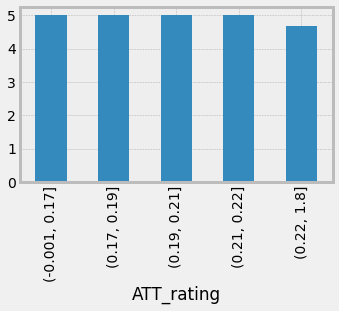

In [7]:
# dependancy of ATT WALL_ENERGY_EFF - we can see that when this field have been filled then in most number of cases rating = 5
df1['ATT_rating'] = pd.qcut(df1.ATT, q = 5)
display(df1.ATT_rating.value_counts())
_ = df1.groupby('ATT_rating')['Wall_rating'].mean().plot(kind = 'bar', figsize = (5,3))

In [8]:
df1['WALL_TYPE'] = df1.WALL_DESCRIPTION.map(lambda x: x.split(',')[0].strip() if not x.startswith(l) else np.nan)
df1['WALL_INS']  = df1.WALL_DESCRIPTION.map(lambda x: x.split(',')[-1].strip() if not x.startswith(l) else np.nan)

In [9]:
df1.WALL_TYPE.value_counts()

Cavity wall               87646
Timber frame              36164
Solid brick               34279
Sandstone or limestone    33550
System built              16719
Granite or whinstone       9114
Park home wall               92
Cob                          23
Name: WALL_TYPE, dtype: int64

In [10]:
df1.WALL_INS.value_counts()

no insulation (assumed)                  83527
insulated (assumed)                      58346
filled cavity                            35798
partial insulation (assumed)             21091
with external insulation                 13762
with internal insulation                  3665
with additional insulation                 619
filled cavity and external insulation      564
filled cavity and internal insulation      134
as built                                    81
Name: WALL_INS, dtype: int64

In [11]:
# we should divide cavity wall and filled cavity wall
f1 = df1.WALL_INS.isin([
    'filled cavity',
    'filled cavity and external insulation',
    'filled cavity and internal insulation'
])
df1.loc[f1,'WALL_TYPE'] = 'Cavity wall filled'

In [12]:
df1.WALL_TYPE.value_counts()

Cavity wall               51150
Cavity wall filled        36496
Timber frame              36164
Solid brick               34279
Sandstone or limestone    33550
System built              16719
Granite or whinstone       9114
Park home wall               92
Cob                          23
Name: WALL_TYPE, dtype: int64

In [13]:
# replace insulation 
df1.loc[df1.WALL_INS == 'filled cavity and external insulation', 'WALL_INS'] = 'with external insulation'
df1.loc[df1.WALL_INS == 'filled cavity and internal insulation', 'WALL_INS'] = 'with internal insulation'
df1.loc[df1.WALL_INS == 'as built', 'WALL_INS'] = ''
df1.loc[df1.WALL_INS == 'filled cavity', 'WALL_INS'] = ''

In [14]:
df1.WALL_INS.value_counts()

no insulation (assumed)         83527
insulated (assumed)             58346
                                35879
partial insulation (assumed)    21091
with external insulation        14326
with internal insulation         3799
with additional insulation        619
Name: WALL_INS, dtype: int64

In [15]:
# after looking at the plot we can conclude that there is no big difference between:
# external insulation, internal insulation, insulated (assumed) - so let's merge them to: yes, partial, no
dict_repl = {
 'no insulation (assumed)': 'no',
 'insulated (assumed)': 'yes',
 '': '',
 'partial insulation (assumed)': 'partial',
 'with external insulation': 'yes',
 'with internal insulation': 'yes',
 'with additional insulation': 'yes'
}
df1['WALL_INS'] = df1.WALL_INS.map(dict_repl)

In [16]:
df1[:3]

,WALL_DESCRIPTION,WALL_ENERGY_EFF,Property_UPRN,Wall_rating,Current energy efficiency rating,Total current energy costs over 3 years (£),CO2 Emissions Current Per Floor Area (kg.CO2/m²/yr),CO2_rating,Total_rating,ATT,ATT_rating,WALL_TYPE,WALL_INS
0,"Cavity wall, as built, no insulation (assumed)",Poor,1001100841,2,53.00,"3,789.00",66.00,1,1.50,NaN,NaN,Cavity wall,no
1,"Cavity wall, filled cavity",Average,1001950838,3,66.00,"4,635.00",44.00,3,3.00,NaN,NaN,Cavity wall filled,
2,"Cavity wall, as built, partial insulation (ass...",Average,1000995515,3,61.00,"3,570.00",68.00,1,2.00,NaN,NaN,Cavity wall,partial


#### 3. Ratings vizualisation

In [17]:
feats_gr = ['WALL_TYPE', 'WALL_INS']
feats_ag = ['Wall_rating', 'CO2_rating', 'Total_rating']
colors_list = ['red','orange','green']

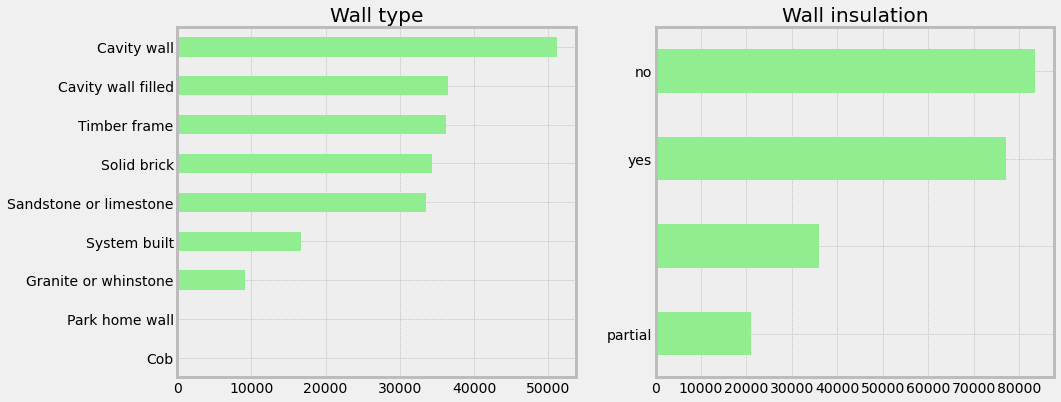

In [18]:
# popularity by wall types and insulation
_, ax = plt.subplots(1,2, figsize = (14,6))
_ = df1.groupby(feats_gr[0]).size().sort_values().plot(kind = 'barh', ax = ax[0], ylabel = '', color = 'lightgreen', title = 'Wall type')
_ = df1.groupby(feats_gr[1]).size().sort_values().plot(kind = 'barh', ax = ax[1], ylabel = '', color = 'lightgreen', title = 'Wall insulation')

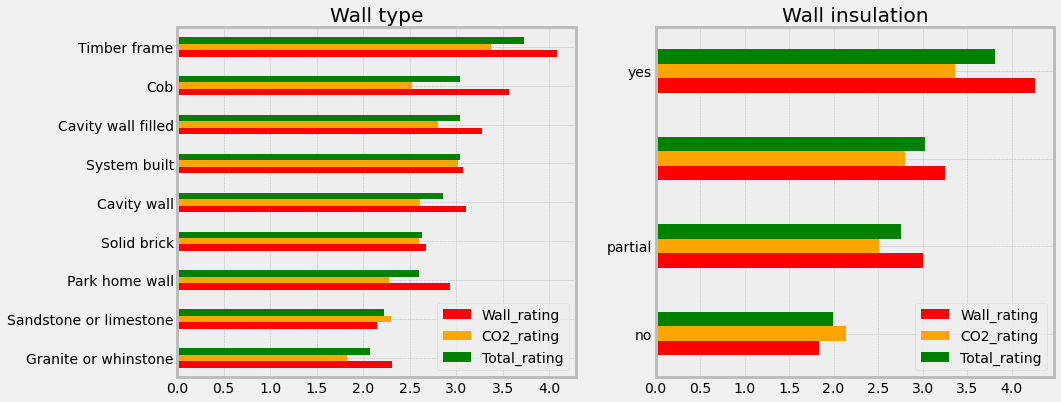

In [19]:
# ratings by wall types and insulation
_, ax = plt.subplots(1,2, figsize = (14,6))
_ = df1.groupby(feats_gr[0])[feats_ag].mean().sort_values('Total_rating').plot(kind = 'barh', ax = ax[0], ylabel = '', color = colors_list, title = 'Wall type')
_ = df1.groupby(feats_gr[1])[feats_ag].mean().sort_values('Total_rating').plot(kind = 'barh', ax = ax[1], ylabel = '', color = colors_list, title = 'Wall insulation')

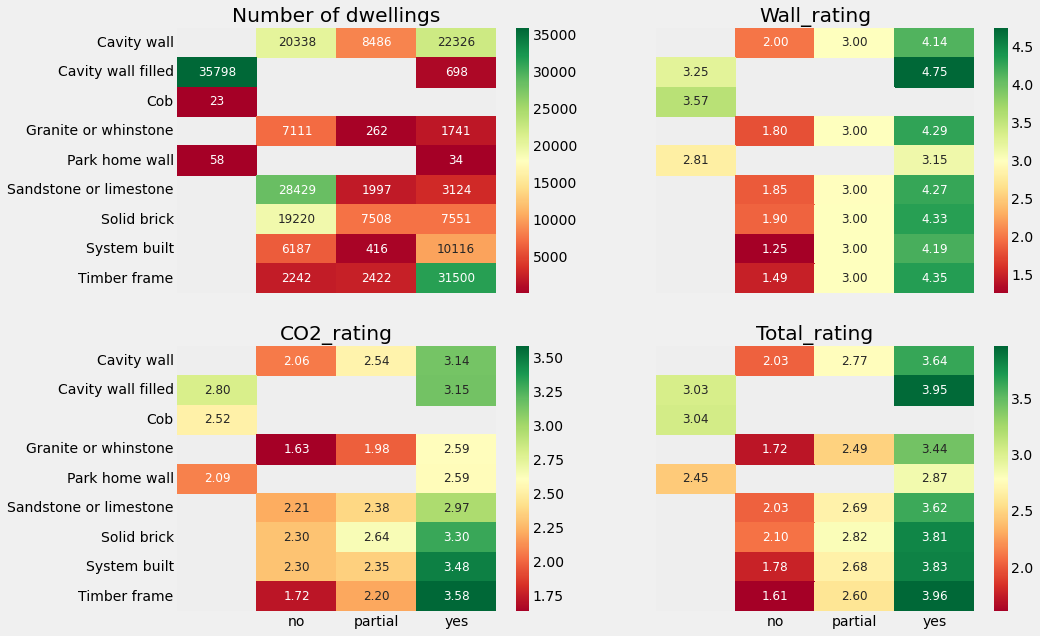

In [20]:
# heatmaps
_, ax = plt.subplots(2,2, figsize = (14,10))

df_corr = df1.groupby(feats_gr).size().unstack()
p = sns.heatmap(df_corr, ax = ax[0][0], cmap = 'RdYlGn', annot = True, fmt = '.0f', annot_kws={"size": 12})
_ = p.set_xlabel('')
_ = p.set_ylabel('')
_ = p.set_title('Number of dwellings')
_ = p.set_xticklabels('')

k = 0
df_corr = df1.groupby(feats_gr)[feats_ag[k]].mean().unstack()
p = sns.heatmap(df_corr, ax = ax[0][1], cmap = 'RdYlGn', annot = True, fmt = '.2f', annot_kws={"size": 12})
_ = p.set_xlabel('')
_ = p.set_yticklabels('')
_ = p.set_xticklabels('')
_ = p.set_ylabel('')
_ = p.set_title(feats_ag[k])

k = 1
df_corr = df1.groupby(feats_gr)[feats_ag[k]].mean().unstack()
p = sns.heatmap(df_corr, ax = ax[1][0], cmap = 'RdYlGn', annot = True, fmt = '.2f', annot_kws={"size": 12})
_ = p.set_xlabel('')
_ = p.set_ylabel('')
_ = p.set_title(feats_ag[k])

k = 2
df_corr = df1.groupby(feats_gr)[feats_ag[k]].mean().unstack()
p = sns.heatmap(df_corr, ax = ax[1][1], cmap = 'RdYlGn', annot = True, fmt = '.2f', annot_kws={"size": 12})
_ = p.set_xlabel('')
_ = p.set_yticklabels('')
_ = p.set_ylabel('')
_ = p.set_title(feats_ag[k])

#### 4. Correlations algorithm
- Create a splittings by the unique combinations of cleaned features values. Wall description and wall energy efficiency in our case have transformed into 3 features: WALL_TYPE, WALL_INS, Wall_rating. Collect CO2 emissions current per floor area values in each group.
- If in one of the group we have less then 100 observations let's replace them as OTHER.
- Plot box-plot to have ability to vizual compare distributions of CO2 values in each group.
- Conduct ANOVA statistical test to have numerical value of similarity between these variables.

In [21]:
# 1) create splittings
feats_gr = [
    'WALL_TYPE', 
    'WALL_INS',
    'Wall_rating'
]
feats_ag = [
    'Current energy efficiency rating',
    'Total current energy costs over 3 years (£)',
    'CO2 Emissions Current Per Floor Area (kg.CO2/m²/yr)'
]
           
df2 = df1.groupby(feats_gr)[feats_ag[-1]].agg([len,np.mean]).reset_index()
df2['group_name'] = df2[feats_gr].apply(lambda x: '_'.join([str(x1) for x1 in x]), axis = 1)
df2.loc[df2['len'] < 100, 'group_name'] = '_OTHER'
del df2['len']
del df2['mean']
print(df2.shape)

# merge with initial dataset
df1 = df1.merge(df2, how = 'left', on = feats_gr)

(56, 4)


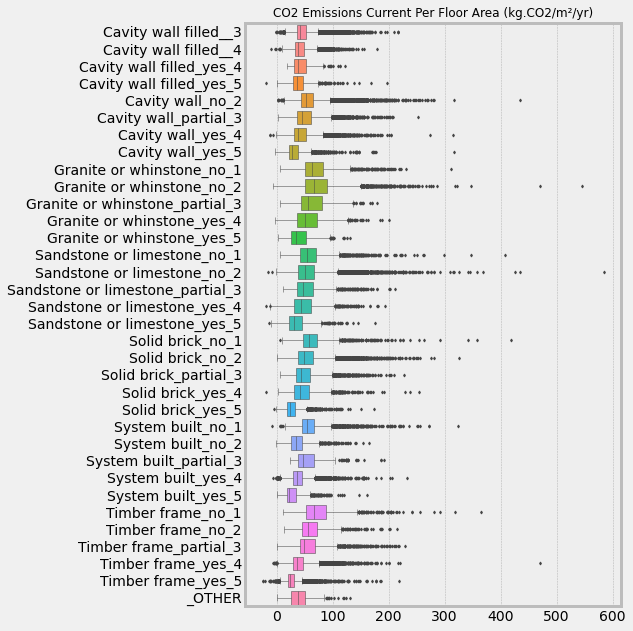

In [22]:
# 2) Plot boxplot to visually compare distributions
list_groups = sorted(df1[~df1.group_name.isnull()].group_name.unique())
feat = feats_ag[-1]
_, ax = plt.subplots(1,1, figsize = (6,10))
p = sns.boxplot(y=df1.group_name, x=df1[feat], ax = ax, order = list_groups, linewidth=0.5, saturation=1, fliersize = 2)
_ = p.set_title(feat, fontsize = 12)
_ = p.set_ylabel('')
_ = p.set_xlabel('')

In [23]:
# 3) Conduct ANOVA statistical test to have numerical value of similarity between these variables.
from scipy import stats
data = df1.groupby('group_name')[feat].agg(lambda x: list(x))
fvalue, pvalue = stats.f_oneway(*data)
fvalue, pvalue

(1244.401594886244, 0.0)

#### 5. Feature engineering
- Calculate average values of features Current energy efficiency rating and Total current energy costs over 3 years (£) by the groups that described above.
- Calculate average of feature rating (if exists, or CO2 rating otherwise).
- Create new features on the Property_UPRN level and replace the categorical features by that 3 new numerical features.
- We will use that features in the modelling and recommendation parts.

In [24]:
# Calculate average values of features Current energy efficiency rating and Total current energy costs over 3 years (£) by the groups.
pre = 'Wall_'
df2 = df1.groupby(feats_gr)[feats_ag[:-1]].agg([len, np.mean])
df2.columns = [pre+'eff_len',pre+'eff_mean',pre+'cost_len',pre+'cost_mean']
df2.reset_index(inplace = True)
df2['group_name'] = df2[feats_gr].apply(lambda x: '_'.join([str(x1) for x1 in x]), axis = 1)
df2.loc[df2[pre+'eff_len'] < 100, 'group_name'] = '_OTHER'
del df2[pre+'eff_len']
del df2[pre+'cost_len']

In [25]:
# Create new features on the Property_UPRN level and replace the categorical features by that new numericals
df2 = df2.groupby('group_name')[pre+'eff_mean',pre+'cost_mean'].mean().reset_index()
df1 = df1.merge(df2)
df3 = df1.groupby('Property_UPRN')[pre+'eff_mean',pre+'cost_mean'].mean().reset_index()

In [26]:
# Add average feature rating
df4 = df1.groupby('Property_UPRN')[pre+'rating'].mean().reset_index()
df3 = df3.merge(df4)
print(df3.shape)
df3[:3]

(162597, 4)


,Property_UPRN,Wall_eff_mean,Wall_cost_mean,Wall_rating
0,1000001648,71.49,"2,274.15",4.00
1,1000001652,59.25,"3,415.16",1.00
2,1000001685,60.99,"3,439.41",2.00


In [27]:
# We will use that features in the modelling part.
df3.to_csv('data/features/WALL_DESCRIPTION.csv', index = False, encoding = 'utf8', sep = '|')